<center>Леховицкий Дмитрий, ст. гр. ПМ-15-1, вариант №7</center>

# Тема 13. Приближенные методы решения начальных задач для ОДУ

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
from numpy import array, linspace
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from sympy import Symbol, latex, init_printing, log, dsolve

x = Symbol('x')
y = Symbol('y')(x)
init_printing()

<a id='plan'></a>

# План

1. [Постановка задачи](#setting)
2. [Одношаговые методы Рунге-Кутты:](#rk)    
    - [Одноэтапные методы (метод Эйлера);](#rk1)
    - [Двухэтапные методы 2-го порядка (метод Хойна, модифицированный метод Эйлера, метод Ралстона);](#rk2)
    - [Методы Рунге-Кутты 4-го порядка (правило $\frac{1}{6}$ и правило $\frac{3}{8}$);](#rk4)
    - [Метод Рунге-Кутты-Мерсона (управление шагом интегрирования)](#rkm)
    - Неявные методы Рунге-Кутты
3. Многошаговые методы
    - Методы Адамса
    - Предиктор-корректорная схема
    - Метод Милна
    - Управление шагом интегрирования
4. Интегрирование систем ОДУ и методы решения ОДУ более высоких порядков
    - Жёсткие системы
    - ОДУ более высоких порядков
5. Практические советы и исследование устойчивости/сходимости
    - Сплайн Шенберга (интерполяция решения)
    - Оценка погрешности
    - Устойчивость методов

<a id='setting'></a>

# Постановка задачи



$$y'=f(x, y),$$
$$y(x_0)=y_0$$

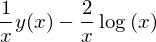

In [2]:
f = y / x  - 2 * log(x) / x
x0, y0 = 1, 1
h, H = 0.1, 1
f

Прежде всего, решим это уравнение аналитически. Это обыкновенное линейное неоднородное ДУ 1-го порядка, которое просто решается методом вариации произвольной постоянной. Его общее решение имеет следующий вид:

In [3]:
dsolve(y.diff(x) - f, y)

Подставляя в это уравнение начальные условия, легко можем найти, что $C_1=-1$. Тогда точное решение нашей начальной задачи

In [4]:
y_true = 2*log(x) - x + 2
Y_true = array([y_true.subs(x, xk) for xk in np.arange(x0, x0+H+h, h)], dtype=np.float)
y_true

Построим график этой функции:

<IPython.core.display.Javascript object>


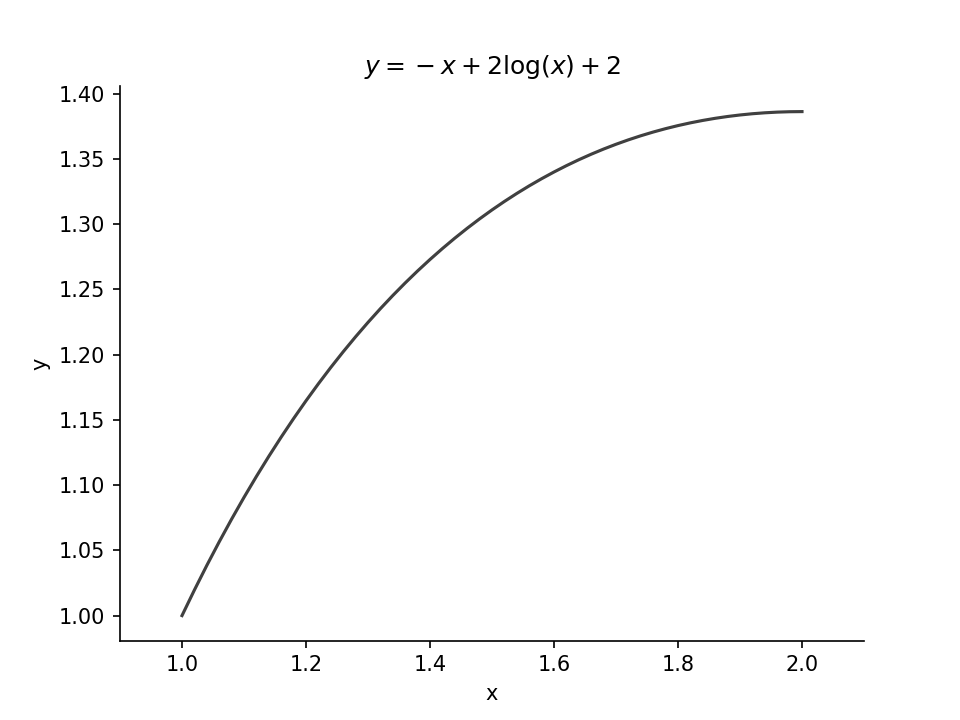

In [5]:
x_grid = linspace(x0, x0+H, 51)
y_grid = array([y_true.subs(x, xk) for xk in x_grid])

plt.figure()
plt.plot(x_grid, y_grid, color='black', alpha=0.75, label='$y(x)$')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.gca().set_xlabel('x'); plt.gca().set_ylabel('y')
plt.gca().set_xlim(x0-h, x0+H+h)
plt.gca().set_title('$y='+latex(y_true)+'$');

[Вверх](#plan)
<a id='rk'></a>

# Методы Рунге-Кутты

Явный метод Рунге-Кутты $m$-го порядка заключается в том, что на каждой итерации вычисляются значения 

$$\begin{align}
k_1 &= f(x_k, y_k), \\
k_2 &= f(x_k + a_2 h, y_k + b_{21} h k_1), \\
k_3 &= f(x_k + a_3 h, y_k + b_{31} h k_1 + b_{32} h k_2), \\
... \\
k_m &= f(x_k + a_m h, y_k + h \sum_{i=1}^{m-1} b_{m j} k_j).
  \end{align}$$
  
После этого значение $y_{k+1}$ вычисляется по формуле 

$$y_{k+1}=y_k + h \sum_{i=1}^m \sigma_i k_i.$$

Коэффициенты метода Рунге-Кутты подбираются так, чтобы достичь максимального порядка точности аппроксимации. Ихудобно подавать в виде таблицы Бутчера:


$$\begin{array}{c|cc}
0 &    &   \\
a_2 & b_{21} &   \\
a_3 & b_{31} & b_{32} \\
... \\
a_m & b_{m1} & b_{m2}& ... & b_{m, m-1} & \\
\hline
    & \sigma_1 & \sigma_2 & ... & \sigma_{m-1} & \sigma_m  \\
\end{array}$$

<a id='rk1'></a>
### Одноэтапные методы 

#### Метод Эйлера

Это единственный одноэтапный метод, имеющий первый порядок точности. Задаётся он коэффициентом $\sigma_1=1$ и формула его имеет вид

$$ y_{k+1}=y_k + h f(x_k, y_k).$$

Таблица Бутчера:

$$\begin{array}{c|c}
0  \\
\hline
  & 1 \\
\end{array}$$


In [6]:
def solve_ode_euler(func, x0, y0, H, h):
    
    X = np.arange(x0, x0+H+h, h)
    N = len(X) - 1
    Y = np.r_[y0, np.zeros(N)]
    
    for k in range(N):
        Y[k+1] = Y[k] + h * func.subs(y, Y[k]).subs(x, X[k])
        
    return Y, X

In [7]:
Y_eul, X_eul = solve_ode_euler(f, x0, y0, H, h)
Y_eul_err = np.abs(array([y_true.subs(x, xk) for xk in X_eul]) - Y_eul)

<IPython.core.display.Javascript object>


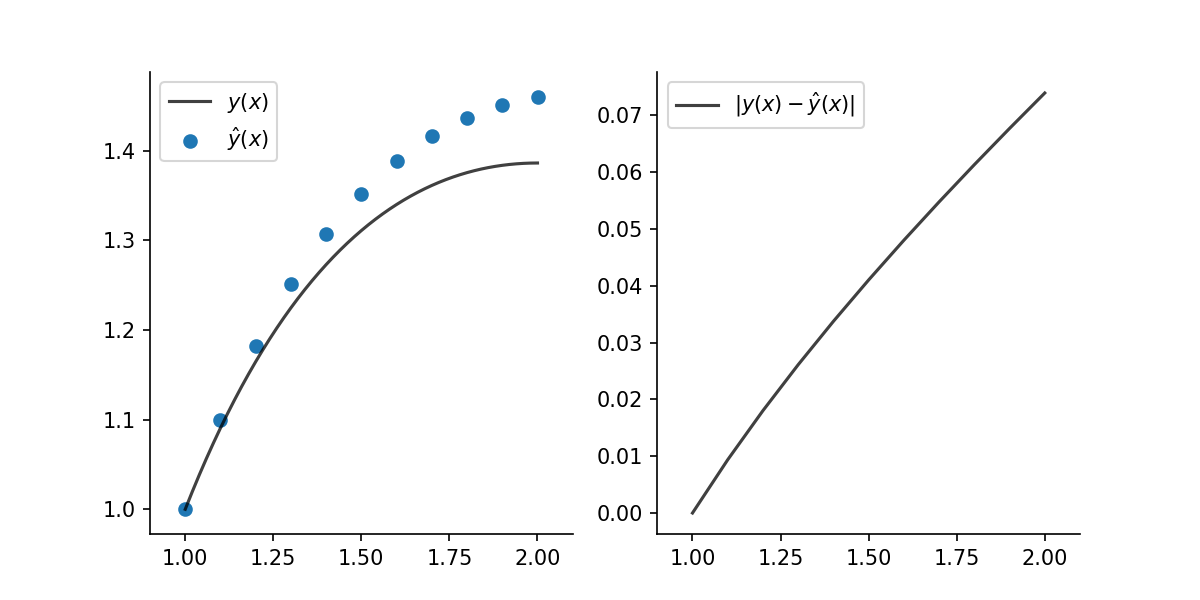

In [8]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(8, 4))

for ax in axes:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlim(x0-h, x0+H+h)

axes[0].plot(x_grid, y_grid, color='black', alpha=0.75, label='$y(x)$')
axes[0].scatter(X_eul, Y_eul, label='$\hat{y}(x)$')

axes[1].plot(X_eul, Y_eul_err, color='black', alpha=0.75, label='$|y(x)-\hat{y}(x)|$')

axes[0].legend()
axes[1].legend();

Видим, что он очень сильно накапливает погрешность, глобальная погрешность метода почти достигает значения величины шага. 

<a id='rk2'></a>
### Двухэтапные методы

Двухэтапные методы 2-го порядка точности задаются такой таблицей Бутчера, имеющей один параметр $\xi$:

$$\begin{array}{c|cc}
0 \\
\xi & \xi \\
\hline
& 1-\frac{1}{2\xi} & \frac{1}{2\xi}
  \end{array}$$


Ниже приведена общая реализация двухэтапных методов Рунге-Кутты с такой таблицей Бутчера

In [9]:
def solve_ode_rk2(func, x0, y0, H, h, xi):
    
    X = np.arange(x0, x0+H+h, h)
    N = len(X) - 1
    Y = np.r_[y0, np.zeros(N)]
    
    for k in range(N):
        k_1 = func.subs(y, Y[k]).subs(x, X[k])
        k_2 = func.subs(y, Y[k]+h*xi*k_1).subs(x, X[k]+h*xi)
        Y[k+1] = Y[k] + h * (k_1 * (2*xi-1) / (2*xi) + k_2 / (2*xi))
        
    return Y, X

Также приведём 3 наиболее часто встречающихся частных случая.

#### 1. Метод Хойна, $\xi=1$

Таблица Бутчера:

$$\begin{array}{c|cc}
0 \\
1 & 1 \\
\hline
& \frac{1}{2} & \frac{1}{2}
  \end{array}$$


Рассчётные формулы метода имеют вид

$$ \begin{align} 
k_1 &= f(x_k, y_k), \\
k_2 &= f(x_k + h, y_k + h k_1), \\
y_{k+1} &= y_k + \frac{h}{2}\left(k_1 + k_2\right).
   \end{align}
$$

In [10]:
def solve_ode_heun(func, x0, y0, H, h):
    return solve_ode_rk2(func, x0, y0, H, h, 1)

In [11]:
Y_heun, X_heun = solve_ode_heun(f, x0, y0, H, h)
Y_heun_err = np.abs(array([y_true.subs(x, xk) for xk in X_heun]) - Y_heun)

<IPython.core.display.Javascript object>


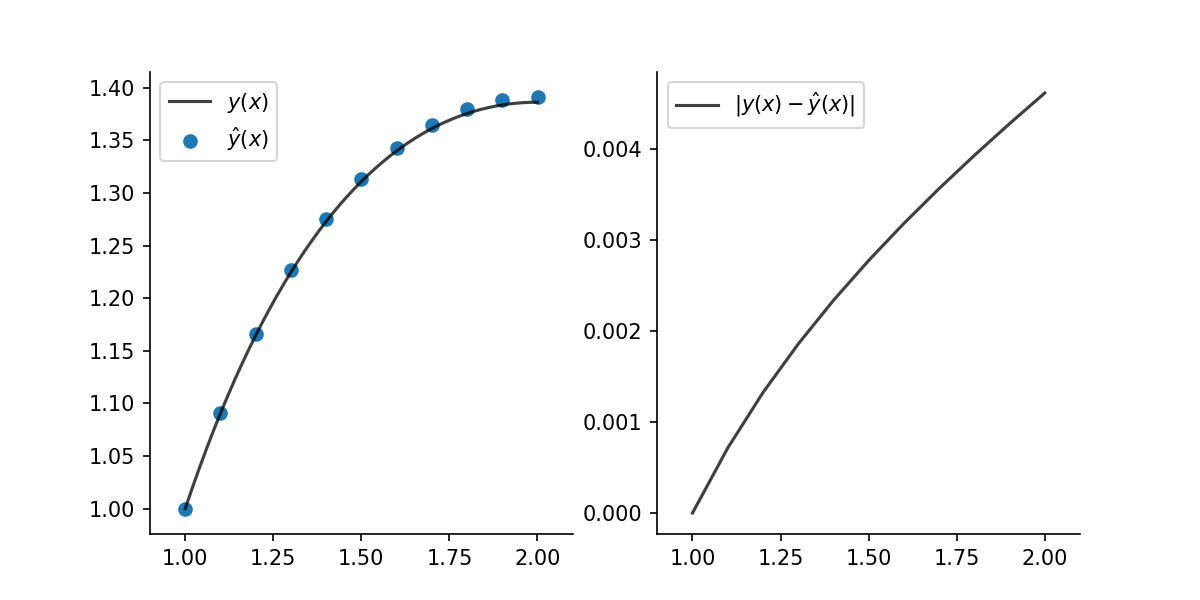

In [12]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(8, 4))

for ax in axes:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlim(x0-h, x0+H+h)

axes[0].plot(x_grid, y_grid, color='black', alpha=0.75, label='$y(x)$')
axes[0].scatter(X_heun, Y_heun, label='$\hat{y}(x)$')

axes[1].plot(X_heun, Y_heun_err, color='black', alpha=0.75, label='$|y(x)-\hat{y}(x)|$')

axes[0].legend()
axes[1].legend();

#### 2. Модифицированный метод Эйлера, $\xi=\frac{1}{2}$


$$\begin{array}{c|cc}
0 \\
\frac{1}{2} & \frac{1}{2} \\
\hline
& 0 & 1
  \end{array}$$


Рассчётные формулы модифицированного метода Эйлера:

$$ \begin{align} 
k_1 &= f(x_k, y_k), \\
k_2 &= f(x_k + \frac{h}{2}, y_k + \frac{h}{2} k_1), \\
y_{k+1} &= y_k + h k_2.
   \end{align}
$$

In [13]:
def solve_ode_mod_eul(func, x0, y0, H, h):
    return solve_ode_rk2(func, x0, y0, H, h, 0.5)

In [14]:
Y_meul, X_meul = solve_ode_mod_eul(f, x0, y0, H, h)
Y_meul_err = np.abs(array([y_true.subs(x, xk) for xk in X_meul]) - Y_meul)

<IPython.core.display.Javascript object>


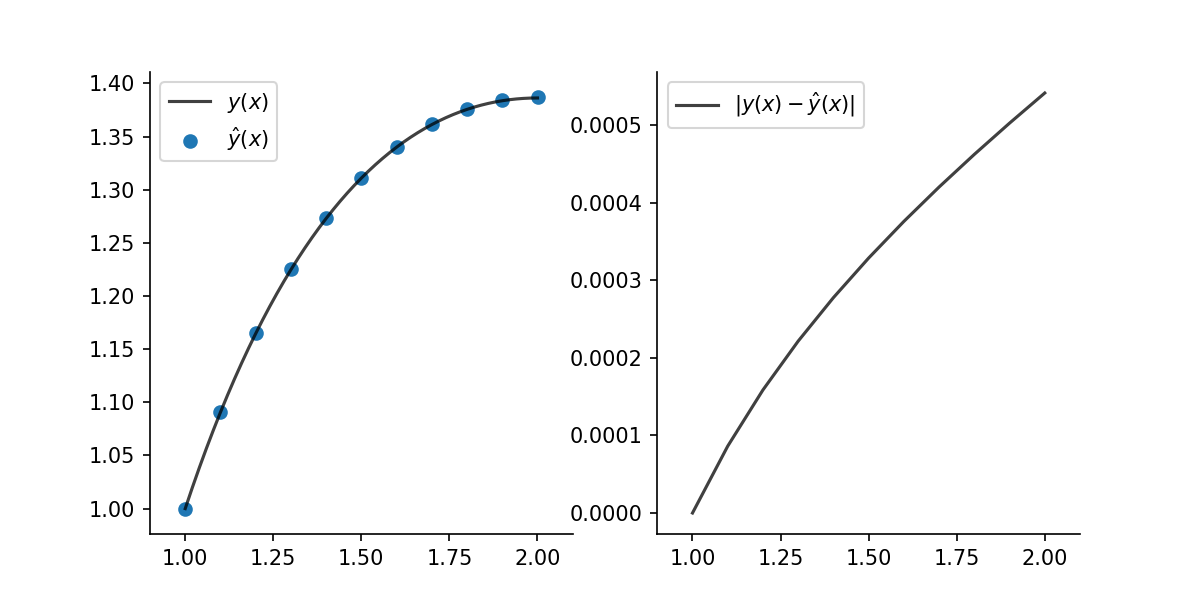

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(8, 4))

for ax in axes:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlim(x0-h, x0+H+h)

axes[0].plot(x_grid, y_grid, color='black', alpha=0.75, label='$y(x)$')
axes[0].scatter(X_meul, Y_meul, label='$\hat{y}(x)$')

axes[1].plot(X_meul, Y_meul_err, color='black', alpha=0.75, label='$|y(x)-\hat{y}(x)|$')

axes[0].legend()
axes[1].legend();

#### 3. Метод Ралстона, $\xi=\frac{2}{3}$

Таблица Бутчера:

$$\begin{array}{c|cc}
0   &    &  \\
\frac{2}{3} & \frac{2}{3} &   \\
\hline
    & \frac{1}{4}   & \frac{3}{4}  \\
\end{array}$$

Рассчётные формулы: 

$$ \begin{align} 
k_1 &= f(x_k, y_k), \\
k_2 &= f(x_k + \frac{2h}{3}, y_k + \frac{2h}{3} k_1), \\
y_{k+1} &= y_k + \frac{h}{4}\left(k_1 + 3k_2\right).
   \end{align}
$$

In [16]:
def solve_ode_ralston(func, x0, y0, H, h):
    return solve_ode_rk2(func, x0, y0, H, h, 2./3)

In [17]:
Y_ralst, X_ralst = solve_ode_ralston(f, x0, y0, H, h)
Y_ralst_err = np.abs(array([y_true.subs(x, xk) for xk in X_meul]) - Y_ralst)

<IPython.core.display.Javascript object>


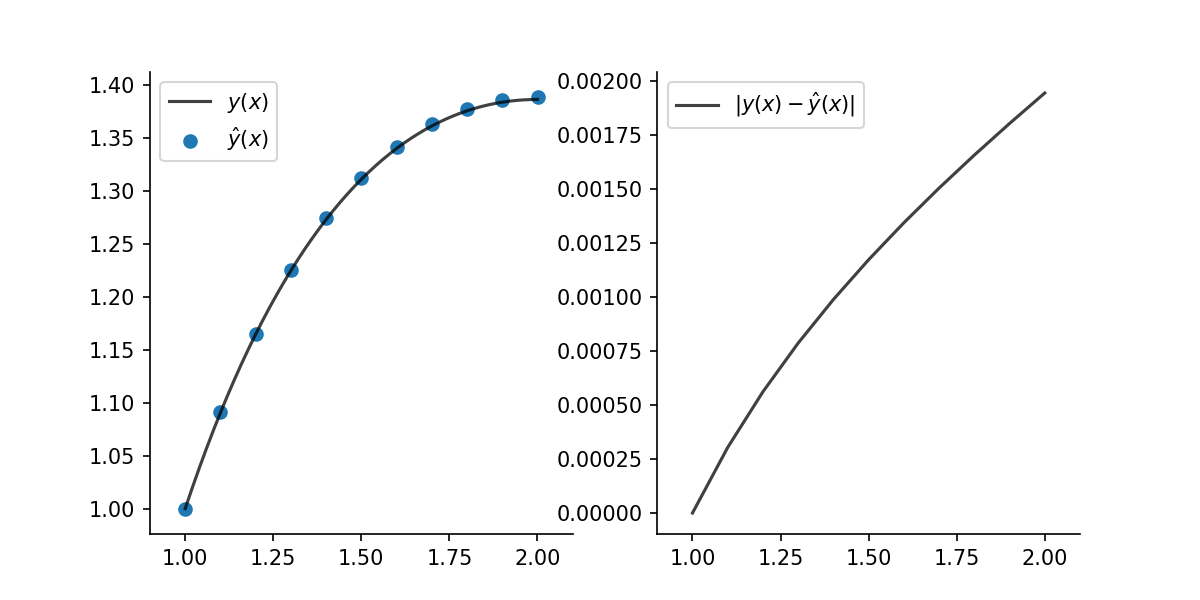

In [18]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(8, 4))

for ax in axes:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlim(x0-h, x0+H+h)

axes[0].plot(x_grid, y_grid, color='black', alpha=0.75, label='$y(x)$')
axes[0].scatter(X_ralst, Y_ralst, label='$\hat{y}(x)$')

axes[1].plot(X_ralst, Y_ralst_err, color='black', alpha=0.75, label='$|y(x)-\hat{y}(x)|$')

axes[0].legend()
axes[1].legend();

<a id='rk4'></a>
### Методы 4-го порядка

Для удобства сразу реализуем функцию для построения общего метода Рунге-Кутты при заданных его параметрах.

In [19]:
def solve_ode_rk(func, x0, y0, H, h, a, B, sig):
    
    X = np.arange(x0, x0+H+h, h)
    N = len(X) - 1
    Y = np.r_[y0, np.zeros(N)]
    
    m = len(sig)
    K = np.zeros(m)
    
    for k in range(N):
        
        K[0] = func.subs(y, Y[k]).subs(x, X[k])
        for j in range(1, m):
            K[j] = (func
                    .subs(y, Y[k] + h*np.dot(B[j-1, :j], K[:j]))
                    .subs(x, X[k] + h*a[j-1]))
        
        Y[k+1] = Y[k] + h * np.dot(sig, K)
        
    return Y, X

Для методов 4-го порядка приведём лишь 2 наиболее употребимых частных случая: правило $\frac{1}{6}$ (классический метод Рунге-Кутты) и правило $\frac{3}{8}$.

#### 1. Правило $\frac{1}{6}$

Это "классический" метод Рунге-Кутты, который задаётся такой таблицей Бутчера:

$$\begin{array}{c|cccc}
0   &   &    &    & \\
\frac{1}{2} & \frac{1}{2} &    &    & \\
\frac{1}{2} & 0   & \frac{1}{2} &    & \\
1   & 0   & 0   & 1   & \\
\hline
    &\frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}\\
\end{array}$$

Рассчётные формулы: 

$$ \begin{align} 
k_1 &= f(x_k, y_k), \\
k_2 &= f(x_k + \frac{h}{2}, y_k + \frac{h}{2} k_1), \\
k_3 &= f(x_k + \frac{h}{2}, y_k + \frac{h}{2} k_2), \\
k_4 &= f(x_k + h, y_k + h k_3),\\
y_{k+1} &= y_k + \frac{h}{6}\left(k_1 + 2k_2 + 2k_3 + k_4\right).
   \end{align}
$$

In [20]:
def solve_ode_rk4_rule16(func, x0, y0, H, h):
    
    a = array([0.5, 0.5, 1])
    B = array([
        [0.5,   0, 0],
        [  0, 0.5, 0],
        [  0,   0, 1]
    ])
    sig = array([1, 2, 2, 1.])/6
    return solve_ode_rk(func, x0, y0, H, h, a, B, sig)

In [21]:
Y_rule16, X_rule16 = solve_ode_rk4_rule16(f, x0, y0, H, h)
Y_rule16_err = np.abs(array([y_true.subs(x, xk) for xk in X_rule16]) - Y_rule16)

<IPython.core.display.Javascript object>


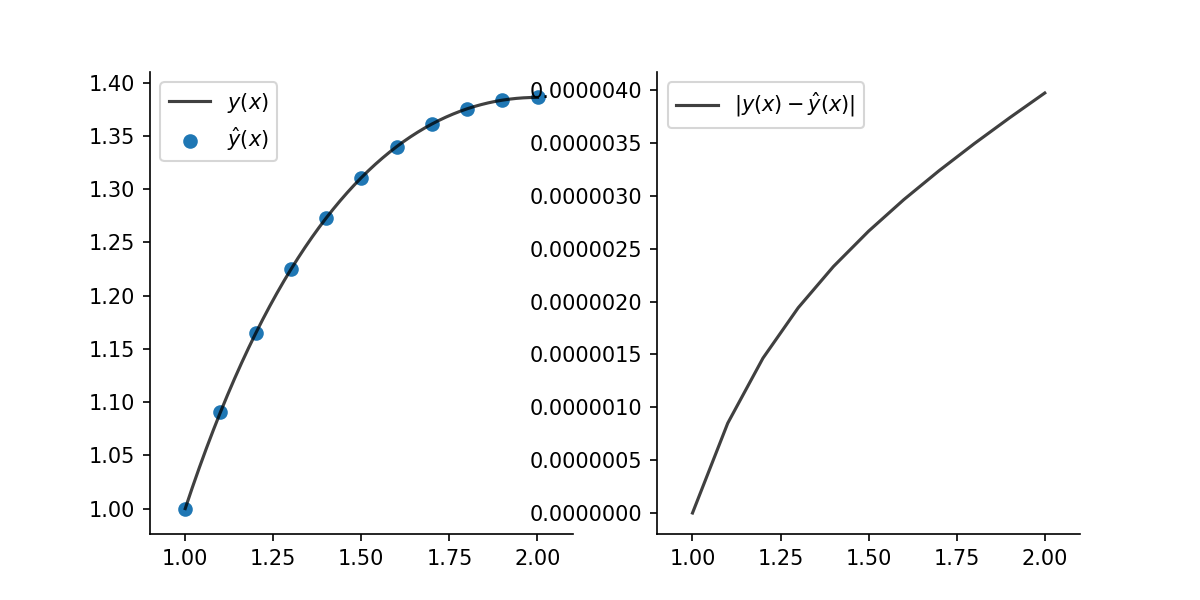

In [22]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(8, 4))

for ax in axes:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlim(x0-h, x0+H+h)

axes[0].plot(x_grid, y_grid, color='black', alpha=0.75, label='$y(x)$')
axes[0].scatter(X_rule16, Y_rule16, label='$\hat{y}(x)$')

axes[1].plot(X_rule16, Y_rule16_err, color='black', alpha=0.75, label='$|y(x)-\hat{y}(x)|$')

axes[0].legend()
axes[1].legend();

#### 2. Правило   $\frac{3}{8}$

Таблица Бутчера: 


$$\begin{array}{c|cccc}
0   &   &    &    & \\
\frac{1}{3} & \frac{1}{3} &    &    & \\
\frac{2}{3} & -\frac{1}{3}   & 1 &    & \\
1   & 1   & -1   & 1   & \\
\hline
    & \frac{1}{8} & \frac{3}{8} & \frac{3}{8} & \frac{1}{8}\\
\end{array}$$


Рассчётные формулы: 

$$ \begin{align} 
k_1 &= f(x_k, y_k), \\
k_2 &= f(x_k + \frac{h}{3}, y_k + \frac{h}{3} k_1), \\
k_3 &= f(x_k + \frac{2h}{3}, y_k - \frac{h}{3} k_1 + h k_2), \\
k_4 &= f(x_k + h, y_k + h k_1 - h k_2 +  h k_3),\\
y_{k+1} &= y_k + \frac{h}{8}\left(k_1 + 3k_2 + 3k_3 + k_4\right).
   \end{align}
$$

In [23]:
def solve_ode_rk4_rule38(func, x0, y0, H, h):
    
    a = array([1/3, 2/3, 1])
    B = array([
        [ 1/3,  0, 0],
        [-1/3,  1, 0],
        [   1, -1, 1]
    ])
    sig = array([1, 3, 3, 1])/8
    return solve_ode_rk(func, x0, y0, H, h, a, B, sig)

In [24]:
Y_rule38, X_rule38 = solve_ode_rk4_rule38(f, x0, y0, H, h)
Y_rule38_err = np.abs(array([y_true.subs(x, xk) for xk in X_rule38]) - Y_rule38)

<IPython.core.display.Javascript object>


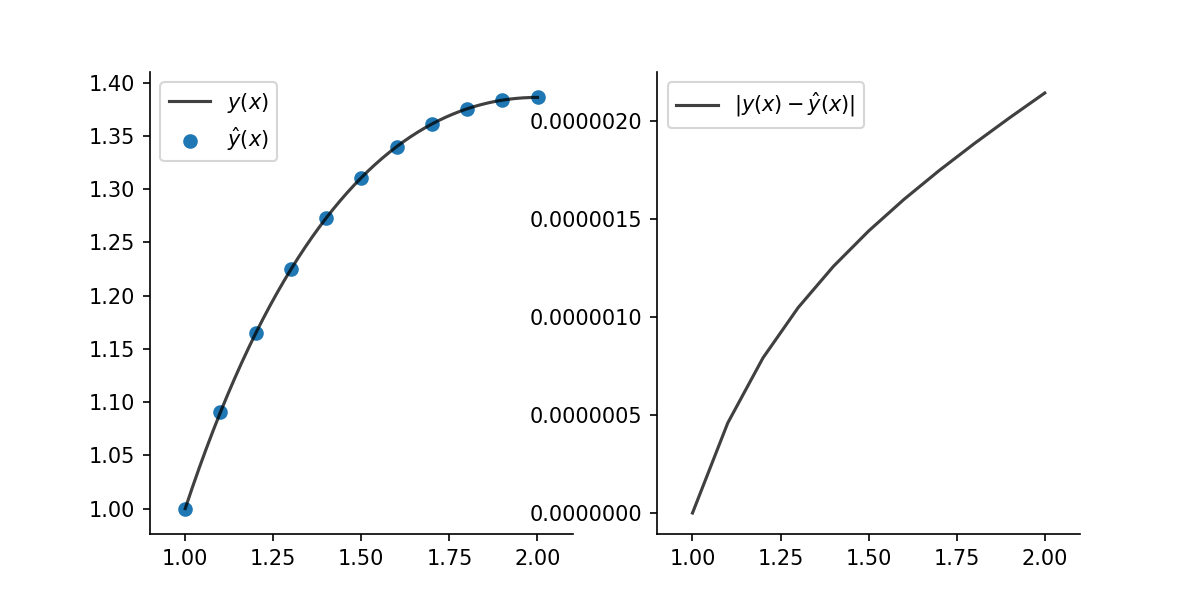

In [25]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(8, 4))

for ax in axes:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlim(x0-h, x0+H+h)

axes[0].plot(x_grid, y_grid, color='black', alpha=0.75, label='$y(x)$')
axes[0].scatter(X_rule38, Y_rule38, label='$\hat{y}(x)$')

axes[1].plot(X_rule38, Y_rule38_err, color='black', alpha=0.75, label='$|y(x)-\hat{y}(x)|$')

axes[0].legend()
axes[1].legend();

#### Сведенная таблица 

In [26]:
df = pd.DataFrame(data='', index=pd.Index([*X_eul, '$\max \\varepsilon_i$'], name='$x_k$'),
                  columns=['Точное решение', 'Метод Эйлера', 'Метод\nХойна', 'Модиф. Эйлер',
                           'Метод Ралстона', 'Правило $\\frac{1}{6}$', 'Правило $\\frac{3}{8}$'])

df.iloc[:-1, 0] = Y_true
df.iloc[:-1, 1] = Y_eul; df.iloc[-1, 1] = '%.2e' % np.abs(Y_eul_err).max()
df.iloc[:-1, 2] = Y_heun; df.iloc[-1, 2] = '%.2e' % np.abs(Y_heun_err).max()
df.iloc[:-1, 3] = Y_meul; df.iloc[-1, 3] = '%.2e' % np.abs(Y_meul_err).max()
df.iloc[:-1, 4] = Y_ralst; df.iloc[-1, 4] = '%.2e' % np.abs(Y_ralst_err).max()
df.iloc[:-1, 5] = Y_rule16; df.iloc[-1, 5] = '%.2e' % np.abs(Y_rule16_err).max()
df.iloc[:-1, 6] = Y_rule38; df.iloc[-1, 6] = '%.2e' % np.abs(Y_rule38_err).max()

df

,Точное решение,Метод Эйлера,Метод Хойна,Модиф. Эйлер,Метод Ралстона,Правило $\frac{1}{6}$,Правило $\frac{3}{8}$
$x_k$,,,,,,,
1.0,1,1,1,1,1,1,1
1.1,1.09062,1.1,1.09134,1.09071,1.09092,1.09062,1.09062
1.2,1.16464,1.18267,1.16597,1.1648,1.1652,1.16464,1.16464
1.3,1.22473,1.25084,1.22659,1.22495,1.22552,1.22473,1.22473
1.4,1.27294,1.30669,1.27528,1.27322,1.27393,1.27295,1.27295
1.5,1.31093,1.35196,1.31371,1.31126,1.3121,1.31093,1.31093
1.6,1.34001,1.38803,1.34319,1.34038,1.34135,1.34001,1.34001
1.7,1.36126,1.41603,1.36483,1.36168,1.36276,1.36126,1.36126
1.8,1.37557,1.4369,1.37951,1.37604,1.37723,1.37558,1.37558


Как видим, наилучший результат в смысле малости локальной погрешности показывает метод 4-го порядка, а именно правило $\frac{3}{8}$.

[Вверх](#plan)
<a id='rkm'></a>

# Метод Рунге-Кутты-Мерсона 


Добавить описание


Прежде мы работали лишь с наперёд заданной равномерной сеткой, по которой стоился каркас решения. Теперь же мы рассмотрим адаптивный метод: в каждой последующей построенной точке значение шага подбирается так, чтобы минимизировать локальную погрешность. 

Итак, рассмотрим метод Рунге-Кутты-Мерсона, который имеет 5-й порядок. Идея его такова: пользуясь таблицей Бутчера ниже, на каждой итерации будем вычислять элементы $\{k_i\}_{i=1}^5$ при текущем шаге $h$. А последние две строки коэффициентов мы используем, чтобы построить уже не одно, а два значения: $y_{k+1}$ - потенциальное значение точного решения в точке $x_{k+1}=x_k + h$ - и $\tilde{y}_{k+1}$ - его оценка. Известно, что разность $E = \tilde{y}_{k+1}-y_{k+1}$ является оценкой (верхней) истинного значения локальной погрешности аппроксимации решения. Его мы и будем использовать для адаптации шага. Если модуль этой оценка больше допустимой точности $\varepsilon$, выбранный шаг не обеспечивает заданной точности, его следует уменьшить в два раза и пересчитать $y_{k+1}$ уже для него. Если же оценка сильно меньше погрешности по модулю ($|E|<\frac{\varepsilon}{32}$), то мы можем позволить себе немного увеличить шаг (в два раза), чтобы не тратить слишком много вычислительных ресурсов. Иначе же шаг оставляют прежним. 

$$\begin{array}{c|ccccc}
  0 \\
  \frac{1}{3} & \frac{1}{3} \\
  \frac{1}{3} & \frac{1}{6} & \frac{1}{6} \\
  \frac{1}{2} & \frac{1}{8} & 0 & \frac{3}{8} \\
  1           & \frac{1}{2} & 0 & -\frac{3}{2} & 2 \\
  \hline
  y_{k+1}     & \frac{1}{6} & 0 & 0 & \frac{2}{3} & \frac{1}{6}\\
  \hline
  \tilde{y}_{k+1}     & \frac{1}{2} & 0 & -\frac{3}{2} & 2 & 0
  \end{array}$$

In [45]:
def solve_ode_rkm(func, x0, y0, H, eps):
    
    Delta = max([abs(x0), abs(x0+H)])**(-5) + abs(func.subs(y, y0).subs(x, x0))**5
    h = (eps / Delta) ** .2
    X = [x0]
    Y = [y0]
    E = []
    h = 0.1
    k = 0
    while X[k] + h < x0 + H:
        
        def next_state(func, xk, yk, h, eps):
            k1 = func.subs(y, yk).subs(x, xk)
            k2 = func.subs(y, yk + h/3*k1).subs(x, xk + h/3)
            k3 = func.subs(y, yk + h/6*k1 + h/6*k2).subs(x, xk + h/3)
            k4 = func.subs(y, yk + h/8*k1 + 3*h/8*k3).subs(x, xk + h/2)
            k5 = func.subs(y, yk + h/2*k1 - 3*h/2*k3 + 2*h*k4).subs(x, xk + h)
            y_next = yk + h / 6 * (k1 + 4*k4 + k5)
            e = h / 6 * (2*k1 - 9*k3 + 8*k4 - k5)
            if abs(e) >= eps:
                move = False; h /= 2
            elif abs(e) >= eps / 32:
                move = True
            else:
                move = False; h *= 2
            return move, h, y_next, e
            
        move, h, y_next, e_next = next_state(func, X[k], Y[k], h, eps)
        while not move:
            print(k, 'hey')
            move, h, y_next, e_next = next_state(func, X[k], Y[k], h, eps)
        
        x_next = X[k] + h
        k += 1
        E.append(e_next); X.append(x_next); Y.append(y_next)
        
    return array(Y), array(X), array(E)

In [56]:
Y_rkm, X_rkm, E = solve_ode_rkm(f, x0, y0, 20, 1e-7)
Y_rkm_err = np.abs(array([y_true.subs(x, xk) for xk in X_rkm]) - Y_rkm)

0 hey
0 hey
27 hey
61 hey
95 hey
129 hey


<IPython.core.display.Javascript object>


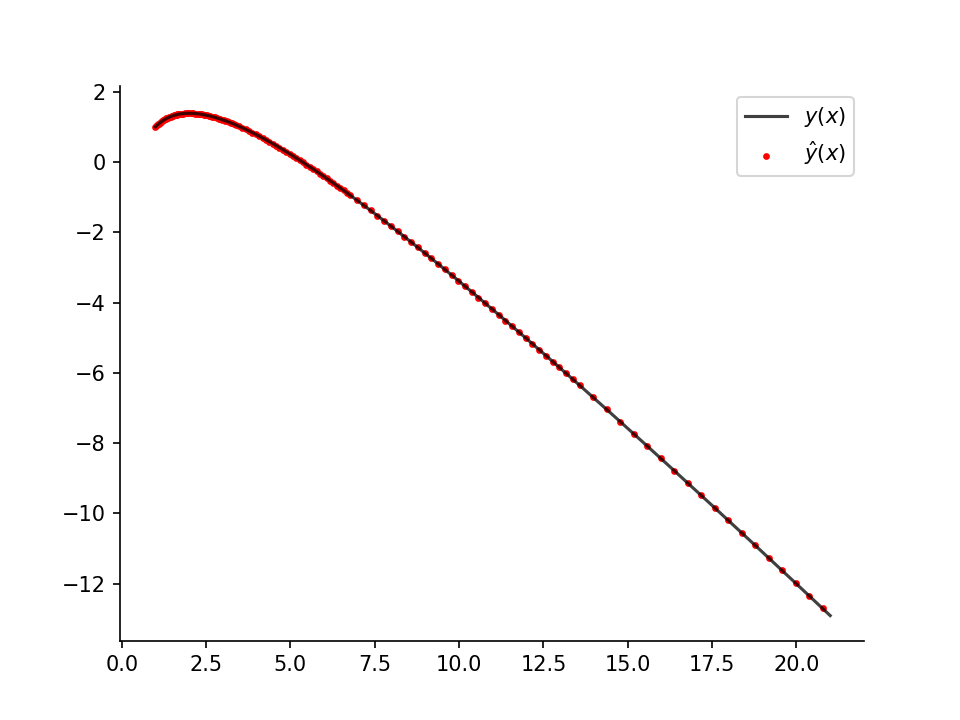

In [57]:
x_grid = linspace(x0, x0 + 20, 251)
y_grid = array([y_true.subs(x, xk) for xk in x_grid])

plt.figure()
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.plot(x_grid, y_grid, c='black', alpha=0.75, label='$y(x)$')
plt.scatter(X_rkm, Y_rkm, s=5, c='r', label='$\hat{y}(x)$')

plt.legend();

<IPython.core.display.Javascript object>


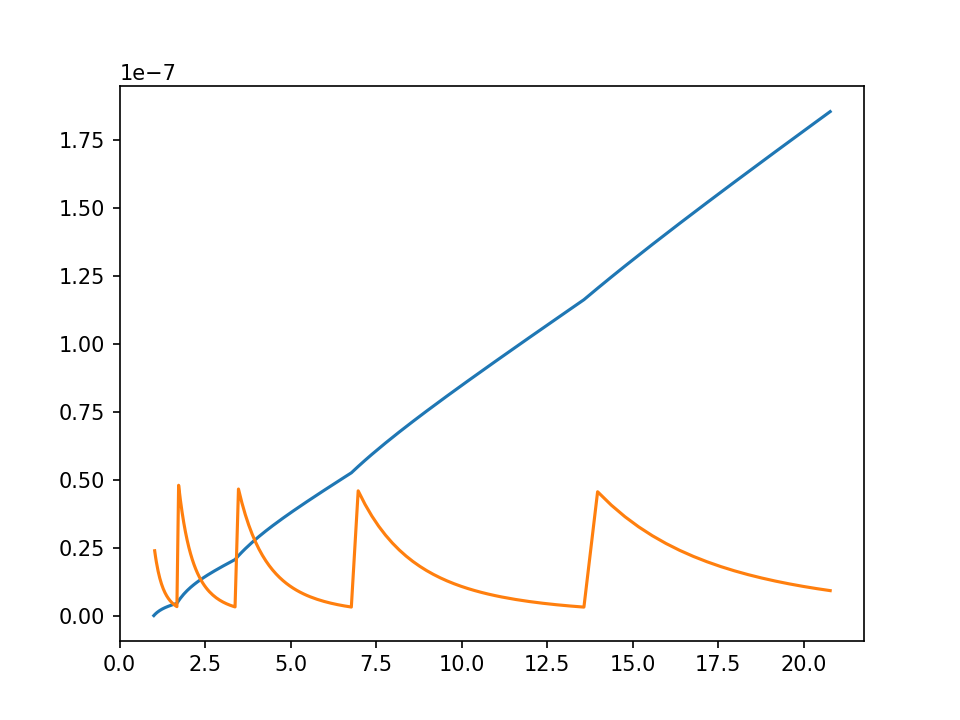

In [58]:
plt.figure()

plt.plot(X_rkm, Y_rkm_err, label='$\varepsilon_k$')
plt.plot(X_rkm[1:], E, label='E_k')

<IPython.core.display.Javascript object>


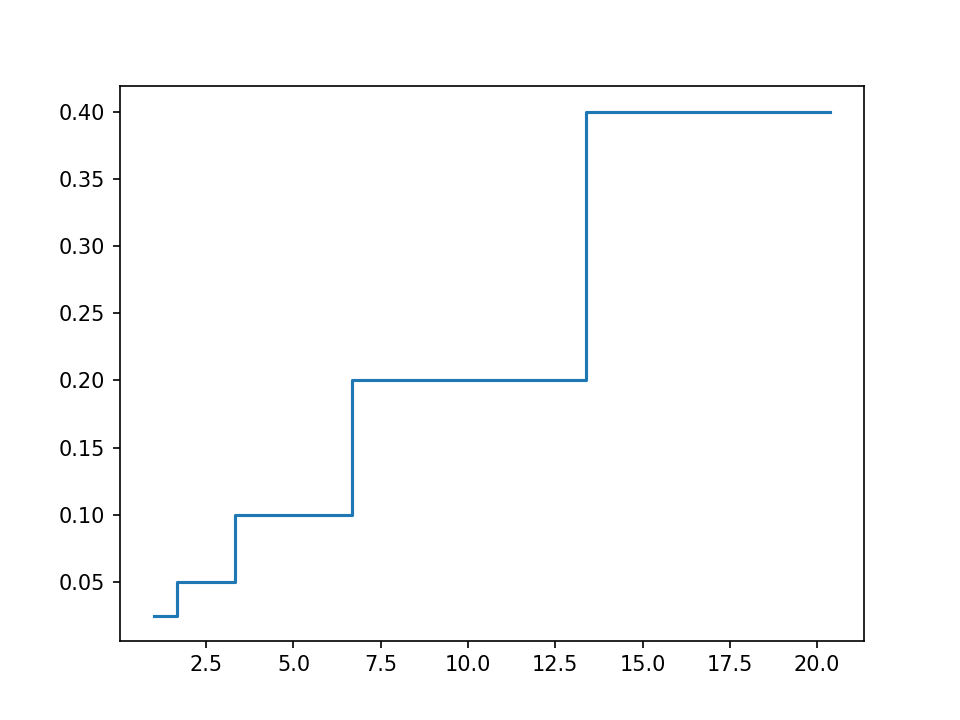

In [59]:
plt.figure()
plt.step(X_rkm[:-1], X_rkm[1:]-X_rkm[:-1])

[Вверх](#plan)

$$y'=xy+x^3,$$
$$y(0)=-2.$$

Точное решение методом вариации произвольной постоянной:

$$y'=xy \Rightarrow \frac{dy}{y}=x dx \Rightarrow y=C e^{\frac{x^2}{2}}.$$

$$y(x)=C(x) e^{\frac{x^2}{2}}$$

 

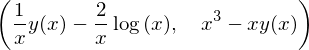

In [34]:
f_contr = - x * y + x**3
x0_contr, y0_contr = 0, -2
y_true_contr = x**2 - 2

f, f_contr

In [70]:
solve_ode_rk4_rule38(f_contr, x0_contr, y0_contr, H, h)

(array([-2.        , -1.98999999, -1.95999995, -1.90999989, -1.8399998 ,
        -1.74999969, -1.63999955, -1.50999939, -1.35999919, -1.18999897,
        -0.99999871]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))

In [69]:
Y_contr_rkm, X_contr_rkm, E = solve_ode_rkm(f_contr, x0_contr, y0_contr, H=20,eps= 1e-7)

hey
hey
hey
hey


<IPython.core.display.Javascript object>


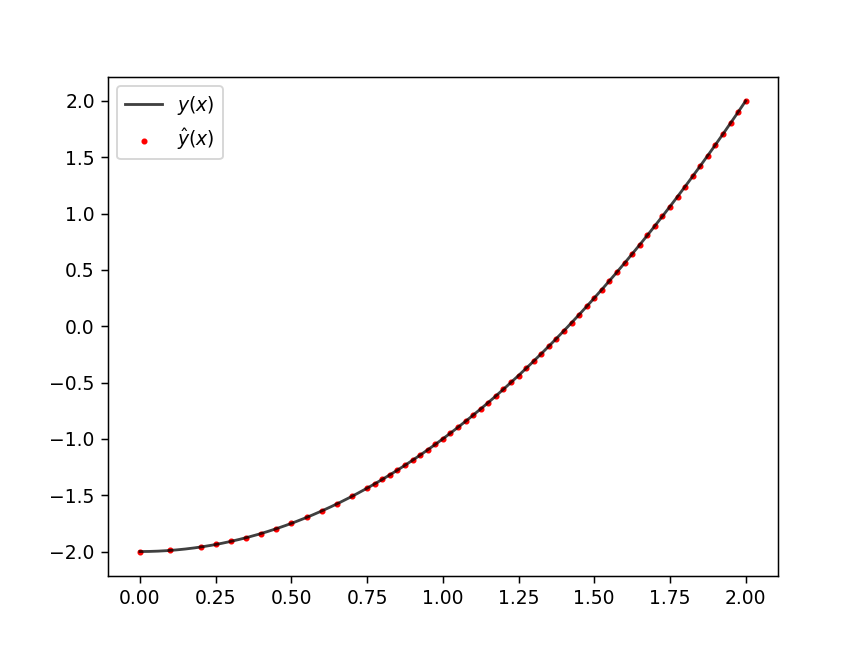

In [68]:
x_grid = linspace(x0_contr, x0_contr + 2, 201)
y_grid = array([y_true_contr.subs(x, xk) for xk in x_grid])

plt.figure()
plt.plot(x_grid, y_grid, c='black', alpha=0.75, label='$y(x)$')
plt.scatter(X_contr_rkm, Y_contr_rkm, s=5, c='r', label='$\hat{y}(x)$')

plt.legend();

<IPython.core.display.Javascript object>


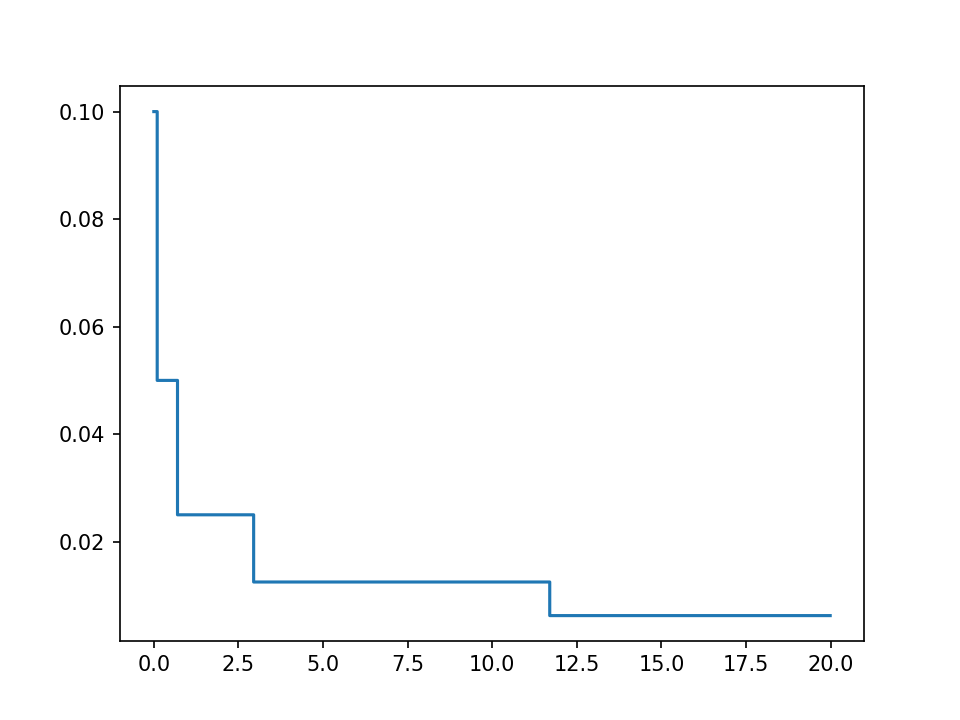

In [70]:
plt.figure()
plt.step(X_contr_rkm[:-1], X_contr_rkm[1:]-X_contr_rkm[:-1])

|      | |          |          |   |              |          |
|------| |----------|----------|---|--------------|----------|
|0     | |          |          |   |              |          |
|$a_2$ | |$b_{21}$  |          |   |              |          |
|$a_3$ | |$b_{31}$  |$b_{32}$  |   |              |          |
|...   | |...       |...       |   |              |          |
|$a_m$ | |$b_{m1}$  |$b_{m2}$  |...|$b_{m,m-1}$   |          |
|      | |          |          |   |              |          |
|      | |$\sigma_1$|$\sigma_2$|...|$\sigma_{m-1}$|$\sigma_m$|
